<a href="https://colab.research.google.com/github/ArtCasual/InGrowCalendar/blob/main/customer_segmentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("libraries imported")

✓ All libraries imported successfully!


In [ ]:
def load_data(filepath='mall_customers.csv'):
    """
    Load customer data from CSV file.

    """

    df = pd.read_csv(filepath)
    print(f"Dataset loaded")

    return df

def explore_data(df):
    """
    Perform initial data exploration.

    Parameters:
    -----------
    df : pd.DataFrame
        Customer dataframe
    """

    display(df.describe())

    print("Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values")
    else:
        print(missing[missing > 0])

df = load_data('mall_customers.csv')
explore_data(df)

Dataset loaded


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Missing Values:
No missing values


In [ ]:
def detect_outliers_iqr(df, columns, threshold=1.5):
    """
    Detect outliers using the Interquartile Range

    """
    outlier_mask = pd.Series([False] * len(df), index=df.index)

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_mask = outlier_mask | col_outliers

        print(f"  {col}: {col_outliers.sum()} outliers")

    return outlier_mask

def preprocess_data(df, remove_outliers=True):
    """
    Preprocess the customer data.

    """
    df_clean = df.copy()
    print("DATA PREPROCESSING")

    # Encode Gender
    if 'Gender' in df_clean.columns:
        df_clean['Gender_Encoded'] = df_clean['Gender'].map({'Male': 0, 'Female': 1})
        print("\n✓ Gender encoded (Male=0, Female=1)")

    # Remove outliers

    if remove_outliers:
        print("\nDetecting outliers in Annual Income and Spending Score:")

        # Find column names (handle different naming conventions)
        income_col = [col for col in df_clean.columns if 'income' in col.lower()][0]
        spending_col = [col for col in df_clean.columns if 'spending' in col.lower()][0]

        outlier_mask = detect_outliers_iqr(df_clean, [income_col, spending_col])

        initial_count = len(df_clean)
        df_clean = df_clean[~outlier_mask]
        removed_count = initial_count - len(df_clean)

        print(f"\n Removed {removed_count} outlier records")
        print(f"  Remaining records: {len(df_clean)}")

    return df_clean


df_clean = preprocess_data(df)

DATA PREPROCESSING

✓ Gender encoded (Male=0, Female=1)

Detecting outliers in Annual Income and Spending Score:
  Annual Income (k$): 2 outliers
  Spending Score (1-100): 0 outliers

 Removed 2 outlier records
  Remaining records: 198


CORRELATION ANALYSIS


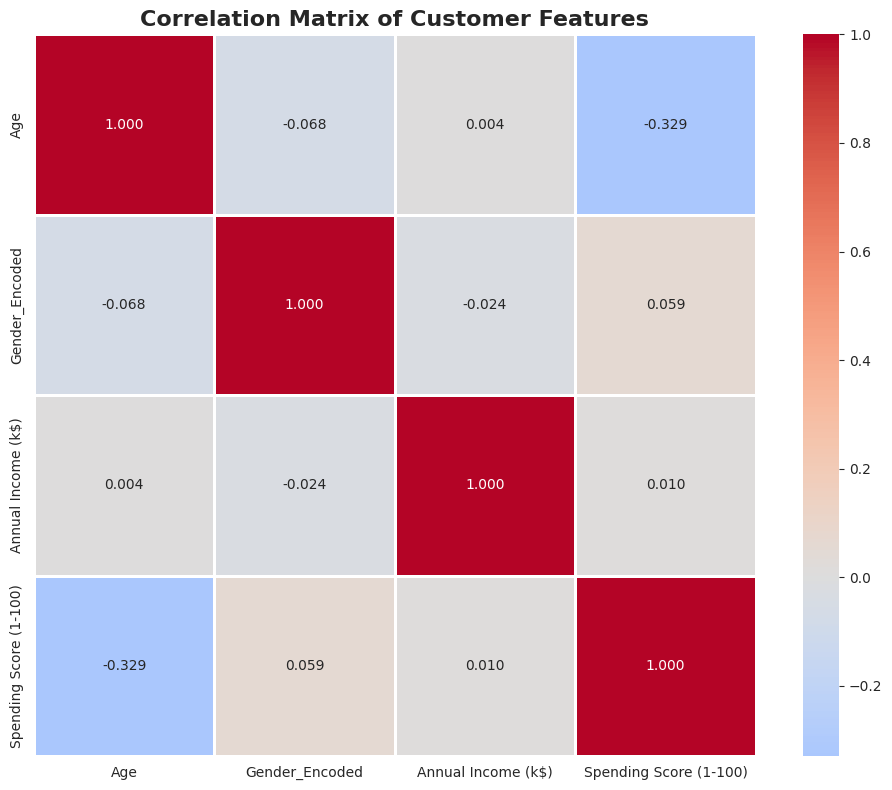


Correlation with Spending Score (1-100):
  Gender_Encoded: 0.059
  Annual Income (k$): 0.010
  Age: -0.329

Interpretation:
  - Gender correlation: 0.059 (weak)
  - Age correlation: 0.329 (moderate)


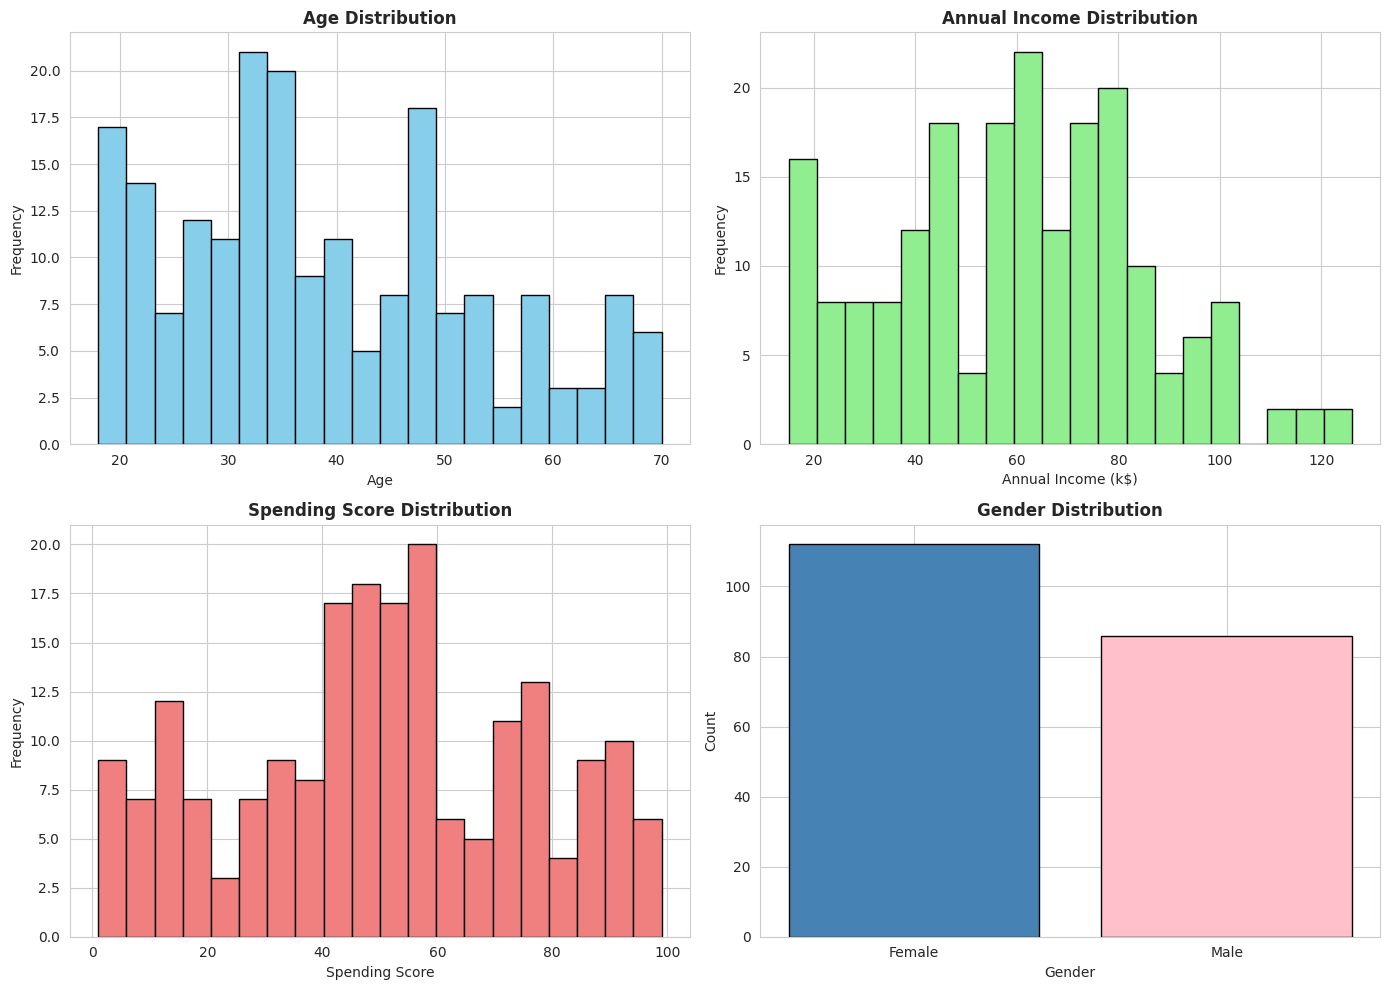

In [ ]:
def analyze_correlations(df):
    """
    Analyze correlations between features and Spending Score.

    Parameters:
    -----------
    df Customer dataframe
    """

    print("CORRELATION ANALYSIS")


    # Find column names
    spending_col = [col for col in df.columns if 'spending' in col.lower()][0]
    income_col = [col for col in df.columns if 'income' in col.lower()][0]

    # Select numeric columns for correlation
    numeric_cols = ['Age', income_col, spending_col]
    if 'Gender_Encoded' in df.columns:
        numeric_cols.insert(1, 'Gender_Encoded')

    corr_matrix = df[numeric_cols].corr()

    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, fmt='.3f')
    plt.title('Correlation Matrix of Customer Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print correlation with Spending Score
    print(f"\nCorrelation with {spending_col}:")
    correlations = corr_matrix[spending_col].sort_values(ascending=False)
    for feature, corr in correlations.items():
        if feature != spending_col:
            print(f"  {feature}: {corr:.3f}")

    # Interpretation
    print("\nInterpretation:")
    age_corr = abs(correlations['Age'])
    if 'Gender_Encoded' in correlations:
        gender_corr = abs(correlations['Gender_Encoded'])
        print(f"  - Gender correlation: {gender_corr:.3f} ({'weak' if gender_corr < 0.3 else 'moderate' if gender_corr < 0.7 else 'strong'})")

    print(f"  - Age correlation: {age_corr:.3f} ({'weak' if age_corr < 0.3 else 'moderate' if age_corr < 0.7 else 'strong'})")

    return corr_matrix

def visualize_feature_distributions(df):
    """
    Visualize the distribution of key features.

    Parameters:
    -----------
    df : pd.DataFrame
        Customer dataframe
    """
    income_col = [col for col in df.columns if 'income' in col.lower()][0]
    spending_col = [col for col in df.columns if 'spending' in col.lower()][0]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Age distribution
    axes[0, 0].hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Age Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Frequency')

    # Income distribution
    axes[0, 1].hist(df[income_col], bins=20, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Annual Income Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Annual Income (k$)')
    axes[0, 1].set_ylabel('Frequency')

    # Spending Score distribution
    axes[1, 0].hist(df[spending_col], bins=20, color='lightcoral', edgecolor='black')
    axes[1, 0].set_title('Spending Score Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Spending Score')
    axes[1, 0].set_ylabel('Frequency')

    # Gender distribution
    if 'Gender' in df.columns:
        gender_counts = df['Gender'].value_counts()
        axes[1, 1].bar(gender_counts.index, gender_counts.values,
                      color=['steelblue', 'pink'], edgecolor='black')
        axes[1, 1].set_title('Gender Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Gender')
        axes[1, 1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Analyze correlations and visualize distributions
corr_matrix = analyze_correlations(df_clean)
visualize_feature_distributions(df_clean)

In [ ]:
def select_features(df, include_age=False, include_gender=False):
    """
    Select features for clustering.

    """
    income_col = [col for col in df.columns if 'income' in col.lower()][0]
    spending_col = [col for col in df.columns if 'spending' in col.lower()][0]

    # Always include Income and Spending Score
    feature_cols = [income_col, spending_col]

    if include_age:
        feature_cols.insert(0, 'Age')

    if include_gender and 'Gender_Encoded' in df.columns:
        feature_cols.insert(0, 'Gender_Encoded')

    X = df[feature_cols].copy()

    print("FEATURE SELECTION")

    print(f"\nSelected features for clustering: {feature_cols}")
    print(f"Feature matrix shape: {X.shape}")

    return X, feature_cols

# Select features (using Income and Spending Score)
X, feature_names = select_features(df_clean, include_age=False, include_gender=False)

FEATURE SELECTION

Selected features for clustering: ['Annual Income (k$)', 'Spending Score (1-100)']
Feature matrix shape: (198, 2)


In [ ]:
def scale_features(X, apply_scaling=True):
    """
    Apply StandardScaler to features.

    """
    if apply_scaling:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print("Features scaled using StandardScaler")
        print(f"  Original range: {X.min().min():.2f} to {X.max().max():.2f}")
        print(f"  Scaled range: {X_scaled.min():.2f} to {X_scaled.max():.2f}")
        return X_scaled, scaler
    else:
        print("Scaling not applied - using original feature values")

        return X.values, None

# Apply scaling
X_scaled, scaler = scale_features(X, apply_scaling=True)

Features scaled using StandardScaler
  Original range: 1.00 to 126.00
  Scaled range: -1.92 to 2.63



Calculating metrics for different k values...
  k=2: Inertia=264.12, Silhouette=0.303
  k=3: Inertia=156.24, Silhouette=0.467
  k=4: Inertia=106.15, Silhouette=0.497
  k=5: Inertia=61.09, Silhouette=0.560
  k=6: Inertia=52.43, Silhouette=0.466
  k=7: Inertia=43.93, Silhouette=0.457
  k=8: Inertia=35.79, Silhouette=0.458
  k=9: Inertia=31.00, Silhouette=0.456
  k=10: Inertia=27.82, Silhouette=0.452


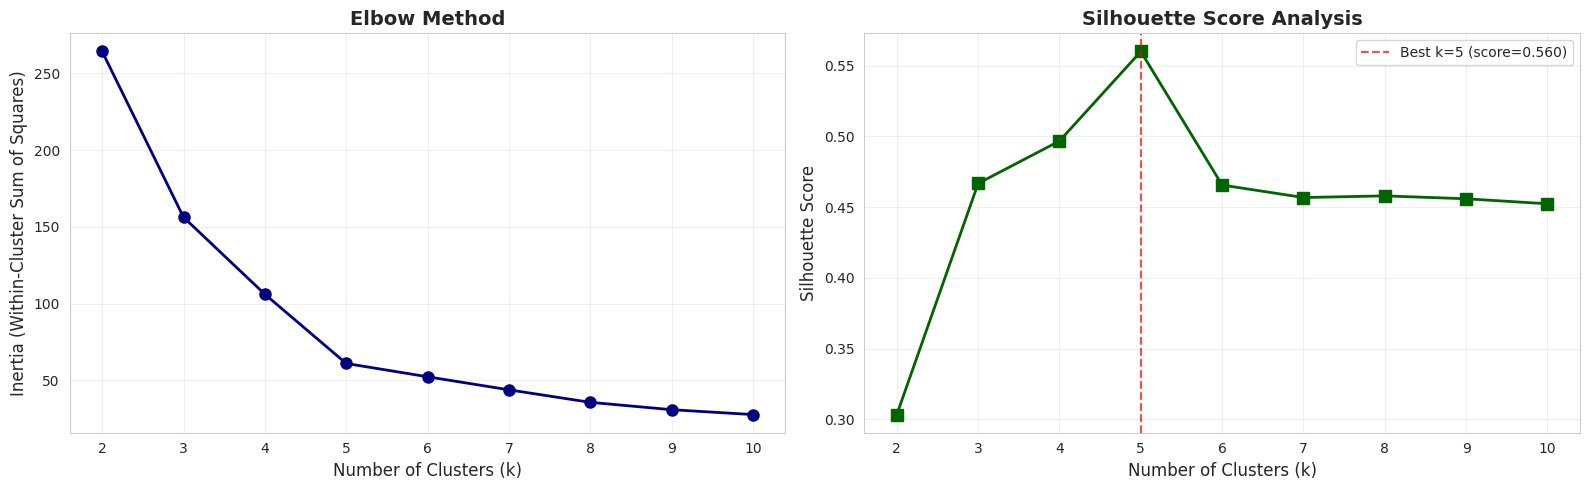

In [ ]:

def plot_elbow_silhouette(metrics):
    """
    Plot Elbow Method and Silhouette Score graphs.

    Parameters:
    -----------
    metrics : dict
        Dictionary containing k values, inertias, and silhouette scores
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Elbow Method
    axes[0].plot(metrics['k_values'], metrics['inertias'],
                marker='o', linewidth=2, markersize=8, color='navy')
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(metrics['k_values'])

    # Silhouette Score
    axes[1].plot(metrics['k_values'], metrics['silhouette_scores'],
                marker='s', linewidth=2, markersize=8, color='darkgreen')
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(metrics['k_values'])

    # Highlight best silhouette score
    best_k_idx = np.argmax(metrics['silhouette_scores'])
    best_k = metrics['k_values'][best_k_idx]
    best_score = metrics['silhouette_scores'][best_k_idx]
    axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7,
                   label=f'Best k={best_k} (score={best_score:.3f})')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return best_k

# Calculate metrics and determine optimal k


metrics = calculate_metrics(X_scaled, k_range=range(2, 11))
optimal_k = plot_elbow_silhouette(metrics)

In [ ]:
def tune_kmeans(X, n_clusters, param_grid=None):
    """
    Tune KMeans parameters to find the best configuration.

    """
    if param_grid is None:
        param_grid = {
            'init': ['k-means++', 'random'],
            'n_init': [10, 20, 30],
            'max_iter': [300, 500]
        }


    best_score = -1
    best_params = None
    best_model = None
    results = []

    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42
                )

                labels = kmeans.fit_predict(X)
                score = silhouette_score(X, labels)

                results.append({
                    'init': init,
                    'n_init': n_init,
                    'max_iter': max_iter,
                    'silhouette': score,
                    'inertia': kmeans.inertia_
                })

                if score > best_score:
                    best_score = score
                    best_params = {'init': init, 'n_init': n_init, 'max_iter': max_iter}
                    best_model = kmeans

    # Display results
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('silhouette', ascending=False)

    display(results_df.head())

    print(f"Best Parameters:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")
    print(f"\n  Best Silhouette Score: {best_score:.4f}")

    return best_model, results_df

# Tune KMeans with optimal k
best_kmeans, tuning_results = tune_kmeans(X_scaled, n_clusters=optimal_k)

,init,n_init,max_iter,silhouette,inertia
0,k-means++,10,300,0.55992,61.086661
1,k-means++,10,500,0.55992,61.086661
2,k-means++,20,300,0.55992,61.086661
3,k-means++,20,500,0.55992,61.086661
4,k-means++,30,300,0.55992,61.086661


Best Parameters:
  - init: k-means++
  - n_init: 10
  - max_iter: 300

  Best Silhouette Score: 0.5599


In [ ]:
def apply_clustering(df, X, model, feature_names):
    """
    Apply clustering model and add cluster labels to dataframe.

    """
    df_clustered = df.copy()
    df_clustered['Cluster'] = model.labels_
    print(f"  Number of clusters: {model.n_clusters}")
    print(f"  Features used: {feature_names}")

    # Cluster distribution
    cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
    print("\nCluster Distribution:")
    for cluster, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"  Cluster {cluster}: {count} customers ({percentage:.1f}%)")

    return df_clustered

def analyze_clusters(df_clustered):
    """
    Analyze characteristics of each cluster.

    """
    income_col = [col for col in df_clustered.columns if 'income' in col.lower()][0]
    spending_col = [col for col in df_clustered.columns if 'spending' in col.lower()][0]

    # Group by cluster and calculate statistics
    cluster_summary = df_clustered.groupby('Cluster').agg({
        'Age': ['mean', 'std'],
        income_col: ['mean', 'std'],
        spending_col: ['mean', 'std'],
        'CustomerID': 'count'
    }).round(2)

    cluster_summary.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std',
                               'Spending_Mean', 'Spending_Std', 'Count']

    print("Cluster Characteristics:")
    display(cluster_summary)

    # Identify high-spending clusters
    high_spending_threshold = df_clustered[spending_col].quantile(0.7)
    high_spending_clusters = cluster_summary[cluster_summary['Spending_Mean'] > high_spending_threshold].index.tolist()

    print(f"HIGH-SPENDING CLUSTERS (Spending Score > {high_spending_threshold:.1f}):")
    for cluster in high_spending_clusters:
        count = cluster_summary.loc[cluster, 'Count']
        avg_income = cluster_summary.loc[cluster, 'Income_Mean']
        avg_spending = cluster_summary.loc[cluster, 'Spending_Mean']
        print(f"  Cluster {cluster}: {count:.0f} customers | Avg Income: ${avg_income:.1f}k | Avg Spending: {avg_spending:.1f}")

    return cluster_summary, high_spending_clusters

# Apply clustering and analyze results
df_clustered = apply_clustering(df_clean, X, best_kmeans, feature_names)
cluster_summary, high_spending_clusters = analyze_clusters(df_clustered)

  Number of clusters: 5
  Features used: ['Annual Income (k$)', 'Spending Score (1-100)']

Cluster Distribution:
  Cluster 0: 22 customers (11.1%)
  Cluster 1: 35 customers (17.7%)
  Cluster 2: 38 customers (19.2%)
  Cluster 3: 80 customers (40.4%)
  Cluster 4: 23 customers (11.6%)

Cluster Characteristics:


,Age_Mean,Age_Std,Income_Mean,Income_Std,Spending_Mean,Spending_Std,Count
Cluster,,,,,,,
0,25.27,5.26,25.73,7.57,79.36,10.50,22
1,40.91,11.57,86.34,14.25,17.57,10.35,35
2,32.76,3.75,85.21,14.24,82.11,9.49,38
3,42.94,16.43,55.09,8.84,49.71,6.33,80
4,45.22,13.23,26.30,7.89,20.91,13.02,23


HIGH-SPENDING CLUSTERS (Spending Score > 61.0):
  Cluster 0: 22 customers | Avg Income: $25.7k | Avg Spending: 79.4
  Cluster 2: 38 customers | Avg Income: $85.2k | Avg Spending: 82.1


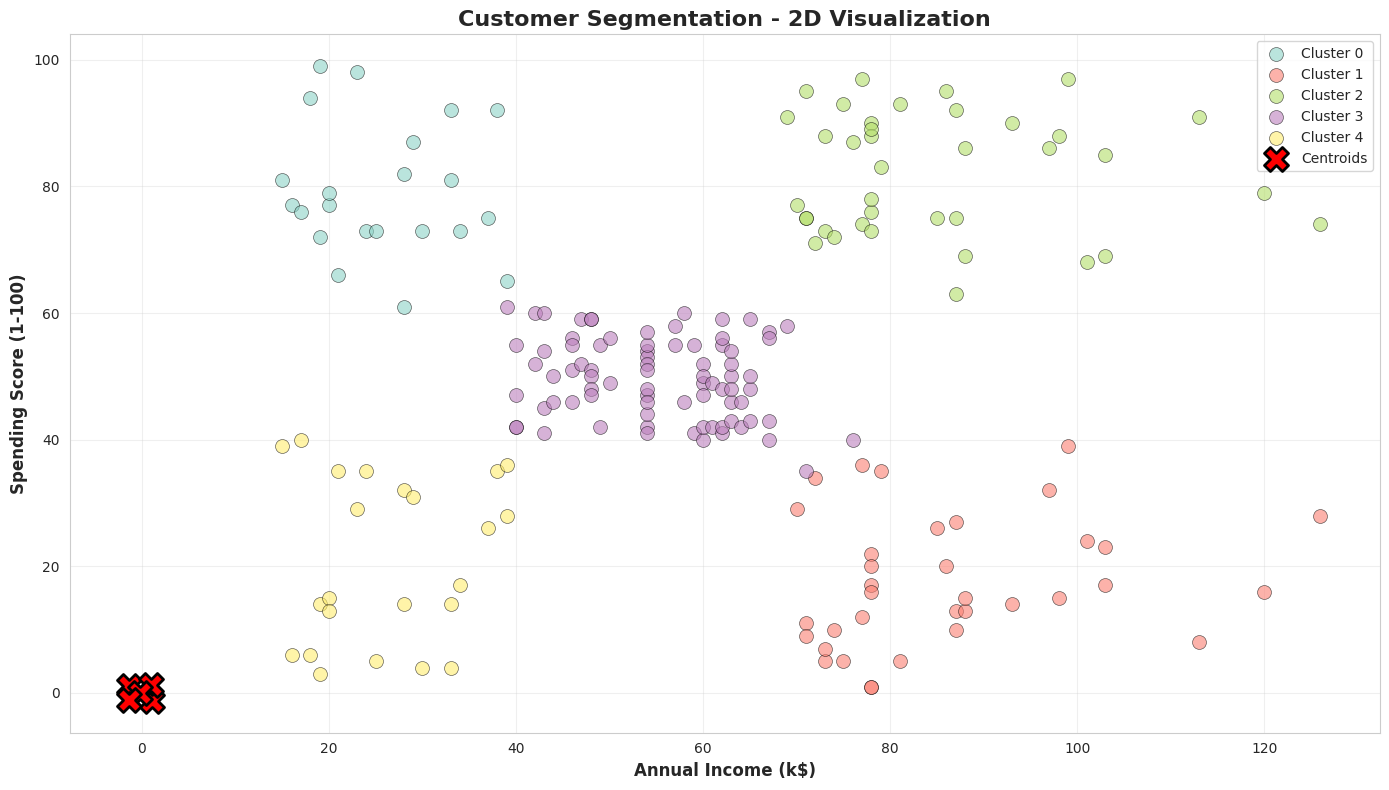

In [ ]:
def plot_clusters_2d(df_clustered, feature_names, centroids=None):
    """
    Plot clusters in 2D space.

    """
    plt.figure(figsize=(14, 8))

    # Get feature columns
    x_col = feature_names[0]
    y_col = feature_names[1]

    # Create color palette
    n_clusters = df_clustered['Cluster'].nunique()
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

    # Plot each cluster
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        plt.scatter(
            cluster_data[x_col],
            cluster_data[y_col],
            c=[colors[cluster]],
            label=f'Cluster {cluster}',
            s=100,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )

    # Plot centroids if available
    if centroids is not None:
        plt.scatter(
            centroids[:, 0],
            centroids[:, 1],
            c='red',
            marker='X',
            s=300,
            edgecolors='black',
            linewidth=2,
            label='Centroids',
            zorder=10
        )

    plt.xlabel(x_col, fontsize=12, fontweight='bold')
    plt.ylabel(y_col, fontsize=12, fontweight='bold')
    plt.title('Customer Segmentation - 2D Visualization', fontsize=16, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_clusters_3d(df_clustered, feature_names):

    """
    Plot clusters in 3D space (if 3+ features).

    """
    if len(feature_names) < 3:
        print("Need at least 3 features for 3D visualization")
        return

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get feature columns
    x_col = feature_names[0]
    y_col = feature_names[1]
    z_col = feature_names[2]

    # Create color palette
    n_clusters = df_clustered['Cluster'].nunique()
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

    # Plot each cluster
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        ax.scatter(
            cluster_data[x_col],
            cluster_data[y_col],
            cluster_data[z_col],
            c=[colors[cluster]],
            label=f'Cluster {cluster}',
            s=100,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )

    ax.set_xlabel(x_col, fontsize=12, fontweight='bold')
    ax.set_ylabel(y_col, fontsize=12, fontweight='bold')
    ax.set_zlabel(z_col, fontsize=12, fontweight='bold')
    ax.set_title('Customer Segmentation - 3D Visualization', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Visualize clusters

plot_clusters_2d(df_clustered, feature_names, centroids=best_kmeans.cluster_centers_)

# If 3+ features, create 3D plot
if len(feature_names) >= 3:
    plot_clusters_3d(df_clustered, feature_names)

In [ ]:
def generate_marketing_insights(df_clustered, cluster_summary, high_spending_clusters):
    """
    Generate business insights and recommendations.

    """

    income_col = [col for col in df_clustered.columns if 'income' in col.lower()][0]
    spending_col = [col for col in df_clustered.columns if 'spending' in col.lower()][0]

    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]

        avg_age = cluster_summary.loc[cluster, 'Age_Mean']
        avg_income = cluster_summary.loc[cluster, 'Income_Mean']
        avg_spending = cluster_summary.loc[cluster, 'Spending_Mean']
        size = cluster_summary.loc[cluster, 'Count']

        # Categorize the segment
        if cluster in high_spending_clusters:
            category = "HIGH-VALUE SEGMENT"
        elif avg_spending > df_clustered[spending_col].median():
            category = "MEDIUM-VALUE SEGMENT"
        else:
            category = "BUDGET-CONSCIOUS SEGMENT"

        print(f"Cluster {cluster}: {category}")
        print(f"Size: {size:.0f} customers ({size/len(df_clustered)*100:.1f}%)")
        print(f"Average Age: {avg_age:.1f} years")
        print(f"Average Income: ${avg_income:.1f}k")
        print(f"Average Spending Score: {avg_spending:.1f}/100")

        # Marketing recommendations
        print("  Marketing Strategy:")
        if cluster in high_spending_clusters:
            print("Priority target for premium products")
            print("VIP loyalty programs and exclusive offers")
            print("Personalized shopping experiences")
            print("Early access to new products")
        elif avg_spending > df_clustered[spending_col].median():
            print("Upselling opportunities")
            print("Bundle deals and combo offers")
            print("Rewards program enrollment")
        else:
            print("Value-focused promotions")
            print("Discount campaigns")
            print("Volume-based incentives")
        print()

    # Overall recommendations
    print("KEY RECOMMENDATIONS FOR MARKETING TEAM:\n")

    total_high_value = sum([cluster_summary.loc[c, 'Count'] for c in high_spending_clusters])
    percentage_high_value = (total_high_value / len(df_clustered)) * 100

    print(f"1. Focus on High-Value Segments (Clusters {high_spending_clusters})")
    print(f" - Represents {total_high_value:.0f} customers ({percentage_high_value:.1f}% of total)")
    print(f" - Allocate premium marketing budget to these segments")
    print(f" - Develop personalized retention strategies\n")

    print("2. Segment-Specific Campaigns")
    print(" - Create tailored messaging for each cluster")
    print(" - Adjust promotion strategies based on spending patterns")
    print(" - Use different channels for different segments\n")

    print("3. Customer Lifetime Value Optimization")
    print(" - Identify customers at risk of moving to lower-spending clusters")
    print(" - Develop programs to upgrade medium-value customers")
    print(" - Monitor cluster transitions over time\n")

    print("4. Resource Allocation")
    print(f" - High-value segments: 50-60% of marketing budget")
    print(f" - Medium-value segments: 30-40% of marketing budget")
    print(f" - Budget-conscious segments: 10-20% (focus on efficiency)\n")

# Generate insights
generate_marketing_insights(df_clustered, cluster_summary, high_spending_clusters)

Cluster 0: HIGH-VALUE SEGMENT
Size: 22 customers (11.1%)
Average Age: 25.3 years
Average Income: $25.7k
Average Spending Score: 79.4/100
  Marketing Strategy:
Priority target for premium products
VIP loyalty programs and exclusive offers
Personalized shopping experiences
Early access to new products

Cluster 1: BUDGET-CONSCIOUS SEGMENT
Size: 35 customers (17.7%)
Average Age: 40.9 years
Average Income: $86.3k
Average Spending Score: 17.6/100
  Marketing Strategy:
Value-focused promotions
Discount campaigns
Volume-based incentives

Cluster 2: HIGH-VALUE SEGMENT
Size: 38 customers (19.2%)
Average Age: 32.8 years
Average Income: $85.2k
Average Spending Score: 82.1/100
  Marketing Strategy:
Priority target for premium products
VIP loyalty programs and exclusive offers
Personalized shopping experiences
Early access to new products

Cluster 3: BUDGET-CONSCIOUS SEGMENT
Size: 80 customers (40.4%)
Average Age: 42.9 years
Average Income: $55.1k
Average Spending Score: 49.7/100
  Marketing Strateg

In [ ]:
def export_results(df_clustered, cluster_summary, output_prefix='customer_segmentation'):
    """
    Export clustering results to CSV files.
    """

    # Export full customer data with clusters
    customers_file = f'{output_prefix}_customers.csv'
    df_clustered.to_csv(customers_file, index=False)
    print(f"data with clusters: {customers_file}")

    # Export cluster summary
    summary_file = f'{output_prefix}_summary.csv'
    cluster_summary.to_csv(summary_file)
    print(f"Cluster summary statistics: {summary_file}")


# Export results
export_results(df_clustered, cluster_summary)

data with clusters: customer_segmentation_customers.csv
Cluster summary statistics: customer_segmentation_summary.csv
